In [2]:
#IMPORT ALL THE REQUIRED LIBERARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
# Optional: for warnings suppression
import warnings
warnings.filterwarnings('ignore')

# Set visualizations inline
%matplotlib inline

In [3]:
# Load the dataset (---)
services = pd.read_csv('SERVICES.csv.gz')

# Preview the dataset
services.head()

,ROW_ID,SUBJECT_ID,HADM_ID,TRANSFERTIME,PREV_SERVICE,CURR_SERVICE
0,758,471,135879,2122-07-22 14:07:27,TSURG,MED
1,759,471,135879,2122-07-26 18:31:49,MED,TSURG
2,760,472,173064,2172-09-28 19:22:15,NaN,CMED
3,761,473,129194,2201-01-09 20:16:45,NaN,NB
4,762,474,194246,2181-03-23 08:24:41,NaN,NB


In [4]:
#  Step 2: Overview + Cleaning
services.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73343 entries, 0 to 73342
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ROW_ID        73343 non-null  int64 
 1   SUBJECT_ID    73343 non-null  int64 
 2   HADM_ID       73343 non-null  int64 
 3   TRANSFERTIME  73343 non-null  object
 4   PREV_SERVICE  14668 non-null  object
 5   CURR_SERVICE  73343 non-null  object
dtypes: int64(3), object(3)
memory usage: 3.4+ MB


In [5]:
# Missing values
missing = services.isnull().sum()
print(missing[missing > 0])

# Drop duplicates
duplicates = services.duplicated().sum()
print(f'Total duplicate rows: {duplicates}')
services.drop_duplicates(inplace=True)

PREV_SERVICE    58675
dtype: int64
Total duplicate rows: 0


In [6]:
#  Step 3: Convert datetime column
services['TRANSFERTIME'] = pd.to_datetime(services['TRANSFERTIME'])
services.dtypes


ROW_ID                   int64
SUBJECT_ID               int64
HADM_ID                  int64
TRANSFERTIME    datetime64[ns]
PREV_SERVICE            object
CURR_SERVICE            object
dtype: object

In [7]:
#  Step 4: Encode categorical columns
for col in ['PREV_SERVICE', 'CURR_SERVICE']:
    services[col + '_ENC'] = services[col].astype('category').cat.codes

services[['PREV_SERVICE', 'PREV_SERVICE_ENC']].drop_duplicates().head()


,PREV_SERVICE,PREV_SERVICE_ENC
0,TSURG,16
1,MED,6
2,NaN,-1
30,CMED,0
45,TRAUM,15


In [8]:
#  Step 5: Normalize numeric column (ROW_ID)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
services['ROW_ID_scaled'] = scaler.fit_transform(services[['ROW_ID']])
services[['ROW_ID', 'ROW_ID_scaled']].head()


,ROW_ID,ROW_ID_scaled
0,758,0.010322
1,759,0.010335
2,760,0.010349
3,761,0.010362
4,762,0.010376


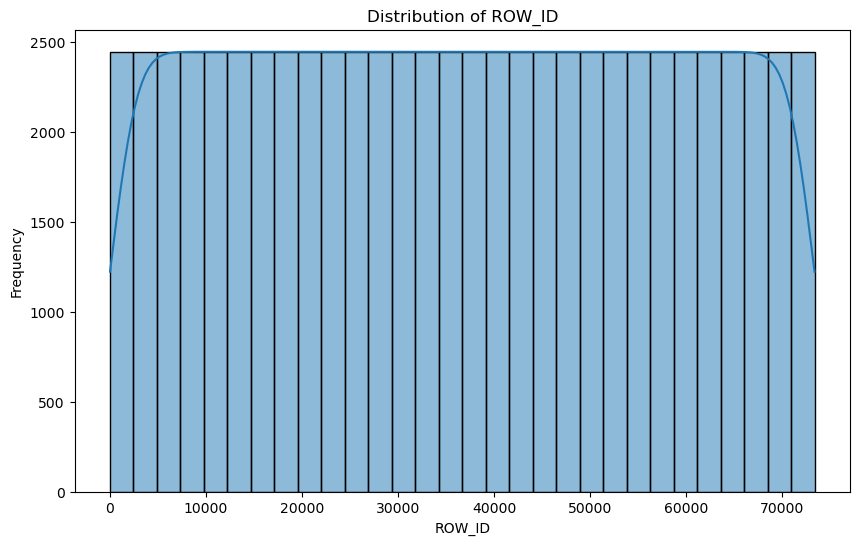

In [9]:
#  Step 6: Plot distribution
plt.figure(figsize=(10,6))
sns.histplot(services['ROW_ID'], kde=True, bins=30)
plt.title('Distribution of ROW_ID')
plt.xlabel('ROW_ID')
plt.ylabel('Frequency')
plt.show()


In [10]:
#  Step 7: Save cleaned dataset
services.to_csv('services_cleaned.csv', index=False)


In [11]:
#  Step 8: Install SDV if needed
!pip install sdv


In [12]:
#  Step 9: SDV Setup
import os
from sdv.single_table import CTGANSynthesizer
from sdv.metadata import SingleTableMetadata

os.environ["NUMBA_NUM_THREADS"] = "1"
os.environ["JOBLIB_START_METHOD"] = "spawn"

services_cleaned = pd.read_csv('services_cleaned.csv')


In [ ]:
#  Step 10: Metadata + Fit
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(services_cleaned)

synthesizer = CTGANSynthesizer(metadata=metadata, epochs=300)
synthesizer.fit(services_cleaned)


In [ ]:
#  Step 11: Sample synthetic data
synthetic_data = synthesizer.sample(num_rows=1000)
synthetic_data.to_csv("synthetic_services.csv", index=False)
synthetic_data.head()


In [ ]:
#  Step 12: Compare distribution
column = 'CURR_SERVICE_ENC'

plt.figure(figsize=(10,5))
sns.histplot(services_cleaned[column], color='blue', label='Real', alpha=0.5, kde=True)
sns.histplot(synthetic_data[column], color='red', label='Synthetic', alpha=0.5, kde=True)

plt.legend()
plt.title(f"Real vs Synthetic: {column}")
plt.show()


In [ ]:
services_cleaned['TARGET'] = (services_cleaned['CURR_SERVICE'] == 'MED').astype(int)
synthetic_data['TARGET'] = (synthetic_data['CURR_SERVICE'] == 'MED').astype(int)

features = ['PREV_SERVICE_ENC', 'CURR_SERVICE_ENC']
target = 'TARGET'

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Real data model
X_real = services_cleaned[features]
y_real = services_cleaned[target]
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_real, y_real, test_size=0.3)

model_real = RandomForestClassifier()
model_real.fit(Xr_train, yr_train)
real_acc = accuracy_score(yr_test, model_real.predict(Xr_test))

# Synthetic data model
X_syn = synthetic_data[features]
y_syn = synthetic_data[target]
Xs_train, Xs_test, ys_train, ys_test = train_test_split(X_syn, y_syn, test_size=0.3)

model_syn = RandomForestClassifier()
model_syn.fit(Xs_train, ys_train)
syn_acc = accuracy_score(ys_test, model_syn.predict(Xs_test))

print(f" Model accuracy on real data:     {real_acc:.2f}")
print(f" Model accuracy on synthetic data:{syn_acc:.2f}")


In [ ]:

#  Import TVAESynthesizer
from sdv.single_table import TVAESynthesizer

#  Initialize VAE synthesizer
vae_synthesizer = TVAESynthesizer(
    metadata=metadata,
    epochs=10
)

# Fit the VAE synthesizer
vae_synthesizer.fit(services_cleaned)

#  Sample synthetic data using VAE
synthetic_data_vae = vae_synthesizer.sample(num_rows=1000)

#  Save VAE synthetic data
synthetic_data_vae.to_csv('synthetic_services_vae.csv', index=False)

#  Preview VAE synthetic data
synthetic_data_vae.head()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load your synthetic data generated from VAE
synthetic_vae = pd.read_csv('synthetic_services_vae.csv')

# Preprocessing: convert categorical columns to numeric codes
features = ['PREV_SERVICE_ENC', 'CURR_SERVICE_ENC']
target = 'TARGET'

# Make sure all datasets are prepared
for col in features:
    services_cleaned[col] = services_cleaned[col].astype('category').cat.codes
    synthetic_vae[col] = synthetic_vae[col].astype('category').cat.codes

# Real data model (already trained if you want, but re-training to be safe)
X_real = services_cleaned[features]
y_real = services_cleaned[target]
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_real, y_real, test_size=0.3, random_state=42)

model_real = RandomForestClassifier(random_state=42)
model_real.fit(Xr_train, yr_train)
real_acc = accuracy_score(yr_test, model_real.predict(Xr_test))

# VAE Synthetic data model
X_vae = synthetic_vae[features]
y_vae = synthetic_vae[target]
Xv_train, Xv_test, yv_train, yv_test = train_test_split(X_vae, y_vae, test_size=0.3, random_state=42)

model_vae = RandomForestClassifier(random_state=42)
model_vae.fit(Xv_train, yv_train)
vae_acc = accuracy_score(yv_test, model_vae.predict(Xv_test))

# Show results
print(f" Model accuracy on real data:       {real_acc:.2f}")
print(f" Model accuracy on VAE synthetic data: {vae_acc:.2f}")


In [ ]:
import matplotlib.pyplot as plt

#  accuracy values
# These are from your previous results:
real_acc = real_acc          # Accuracy on real data using real training
vae_acc = vae_acc           # Accuracy on synthetic VAE data
gan_acc = syn_acc           # Accuracy on synthetic GAN (CTGAN) data

# Prepare bar chart data
labels = ['Real Data (Original)', 'CTGAN (Synthetic)', 'TVAE (Synthetic)']
accuracy_scores = [real_acc, gan_acc, vae_acc]

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(labels, accuracy_scores, color=['skyblue', 'orange', 'green'])

#  chart elements
plt.title('Model Accuracy Comparison: Real vs CTGAN vs TVAE', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy Score')
plt.ylim(0.2, 1.5)
plt.grid(axis='y', linestyle='--', alpha=0.4)

# Annotate bars
for i, acc in enumerate(accuracy_scores):
    plt.text(i, acc + 0.01, f"{acc:.2f}", ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()